# 1. Introduction 
In this notebook, we will perform simple binary image classification using PyTorch. For the Dataset, we will use pizza or not pizza dataset image from kaggle.com<br>
First we need download the dataset

In [1]:
import pandas as pd
!pip install -q jcopdl

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
! unzip -q /content/gtzan-dataset-music-genre-classification.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


we will use torchvision to do classification task

In [3]:
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

because google colab has GPU hardware accelerator for instance runtime, we will use it since it will speed up training model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ImageFolder("/content/Data/images_original")
trainData, testData, trainLabel, testLabel = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42, stratify=dataset.targets)
device

device(type='cuda')

In this task, we will use MobileNet v2 as based model for transfer learning

# 2. Dataset and ImageLoader

In [5]:
bs = 32
crop_size = 224

transformer = {
    "train": transforms.Compose([
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    "test": transforms.Compose([
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

In [6]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = self.checkChannel(dataset)
        self.transform = transform

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            # if Image.open(dataset[index][0]).getbands() == ("R", "G", "B"):
            datasetRGB.append(dataset[index])
        return datasetRGB

    """def getResizedImage(self, item):
        image = Image.open(self.dataset[item][0])
        _, _ , width, height = image.getbbox()
        factor = (0,0,width,width) if width > height else (0,0,height,height)
        return image.crop(factor)"""

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        image = image.convert("RGB")
        if self.transform is not None:
            return self.transform(image), self.dataset[item][1]
        return image, self.dataset[item][1]

    def __len__(self):
        return len(self.dataset)

train_set = ImageLoader(trainData, transformer["train"])
test_set = ImageLoader(testData, transformer["test"])

trainLoader = DataLoader(train_set, batch_size=bs, shuffle=True)
testLoader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
label2cat = dataset.classes

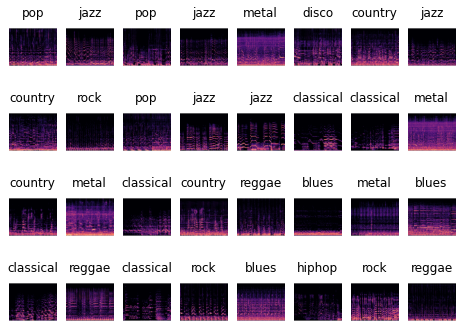

In [8]:
feature, target = next(iter(trainLoader))
fig, axes = plt.subplots(4, 8, figsize=(8, 6))

for f, t, ax in zip(feature, target, axes.flatten()):
    ax.imshow(f.permute(1, 2, 0))
    ax.set_title(label2cat[t])
    ax.axis("off")

In [9]:
from torchvision.models import mobilenet_v2
from torch import nn

In [22]:
class CustomMobilenet(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.classes = dataset
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, len(self.classes)),
            nn.LogSoftmax()
        )
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [23]:
import torch
from jcopdl.callback import Callback, set_config

# 3. MCOC (Model, Criterion, Optimizers, and Callback) 

In [24]:
config = set_config({"batch_size": 32,"crop_size": 224})

In [25]:
model = CustomMobilenet(dataset=label2cat).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, early_stop_patience=3, outdir='model', plot_every=100)

In [26]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title(), leave=False):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

# 4. Adaptation

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 2.3183 | Test_cost  = 2.2620 | Train_score = 0.1277 | Test_score = 0.1750 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 2.1640 | Test_cost  = 2.1338 | Train_score = 0.2428 | Test_score = 0.2650 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 2.0459 | Test_cost  = 2.0253 | Train_score = 0.3867 | Test_score = 0.3550 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.9414 | Test_cost  = 1.9316 | Train_score = 0.4493 | Test_score = 0.4150 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.8561 | Test_cost  = 1.8538 | Train_score = 0.4718 | Test_score = 0.4250 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.7752 | Test_cost  = 1.7864 | Train_score = 0.4906 | Test_score = 0.4650 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.7083 | Test_cost  = 1.7308 | Train_score = 0.5319 | Test_score = 0.4850 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.6476 | Test_cost  = 1.6773 | Train_score = 0.5569 | Test_score = 0.5100 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.6040 | Test_cost  = 1.6372 | Train_score = 0.5732 | Test_score = 0.5100 |
==> EarlyStop patience =  1 | Best test_score: 0.5100


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.5510 | Test_cost  = 1.5857 | Train_score = 0.5895 | Test_score = 0.5250 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.5133 | Test_cost  = 1.5525 | Train_score = 0.5857 | Test_score = 0.5300 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1.4650 | Test_cost  = 1.5179 | Train_score = 0.6095 | Test_score = 0.5550 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 1.4508 | Test_cost  = 1.4875 | Train_score = 0.5882 | Test_score = 0.5500 |
==> EarlyStop patience =  1 | Best test_score: 0.5550


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 1.4096 | Test_cost  = 1.4553 | Train_score = 0.6258 | Test_score = 0.5650 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 1.3697 | Test_cost  = 1.4295 | Train_score = 0.6433 | Test_score = 0.5900 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 1.3485 | Test_cost  = 1.4093 | Train_score = 0.6408 | Test_score = 0.5950 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 1.3397 | Test_cost  = 1.3822 | Train_score = 0.6383 | Test_score = 0.6100 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 1.2978 | Test_cost  = 1.3684 | Train_score = 0.6483 | Test_score = 0.5800 |
==> EarlyStop patience =  1 | Best test_score: 0.6100


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 1.2822 | Test_cost  = 1.3463 | Train_score = 0.6658 | Test_score = 0.6100 |
==> EarlyStop patience =  2 | Best test_score: 0.6100


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 1.2568 | Test_cost  = 1.3365 | Train_score = 0.6596 | Test_score = 0.6100 |
==> EarlyStop patience =  3 | Best test_score: 0.6100
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.6100
==> Best model is saved at model


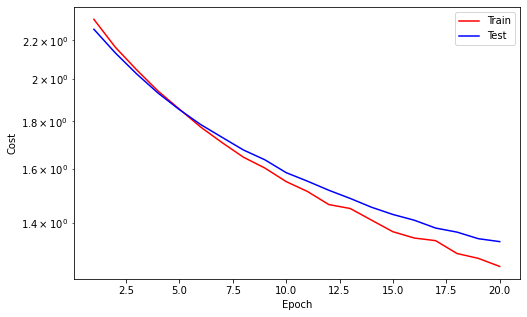

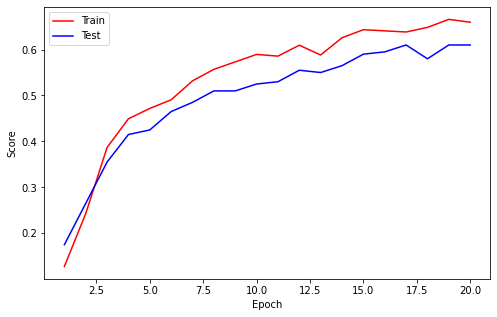

In [27]:
def looping():
    while True:
        train_cost, train_score = loop_fn("train", train_set, trainLoader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", test_set, testLoader, model, criterion, optimizer, device)
        
        # Logging
        callback.log(train_cost, test_cost, train_score, test_score)

        # Checkpoint
        callback.save_checkpoint()
            
        # Runtime Plotting
        callback.cost_runtime_plotting()
        callback.score_runtime_plotting()
        
        # Early Stopping
        if callback.early_stopping(model, monitor="test_score"):
            callback.plot_cost()
            callback.plot_score()
            break
looping()

# 5. Fine Tuning

In [28]:
model.unfreeze()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
callback = Callback(model, config, early_stop_patience=5, outdir='model')

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.2811 | Test_cost  = 1.2739 | Train_score = 0.6433 | Test_score = 0.6150 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.1407 | Test_cost  = 1.1948 | Train_score = 0.6921 | Test_score = 0.6350 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.0455 | Test_cost  = 1.1310 | Train_score = 0.7284 | Test_score = 0.6400 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.9666 | Test_cost  = 1.0831 | Train_score = 0.7459 | Test_score = 0.6650 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.9080 | Test_cost  = 1.0337 | Train_score = 0.7710 | Test_score = 0.7000 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.8279 | Test_cost  = 0.9930 | Train_score = 0.8023 | Test_score = 0.6950 |
==> EarlyStop patience =  1 | Best test_score: 0.7000


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.7794 | Test_cost  = 0.9596 | Train_score = 0.8198 | Test_score = 0.7100 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.7282 | Test_cost  = 0.9240 | Train_score = 0.8185 | Test_score = 0.7300 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.6759 | Test_cost  = 0.8952 | Train_score = 0.8385 | Test_score = 0.7200 |
==> EarlyStop patience =  1 | Best test_score: 0.7300


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.6195 | Test_cost  = 0.8706 | Train_score = 0.8673 | Test_score = 0.7300 |
==> EarlyStop patience =  2 | Best test_score: 0.7300


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.5661 | Test_cost  = 0.8484 | Train_score = 0.8861 | Test_score = 0.7250 |
==> EarlyStop patience =  3 | Best test_score: 0.7300


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.5185 | Test_cost  = 0.8261 | Train_score = 0.8999 | Test_score = 0.7350 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4824 | Test_cost  = 0.8093 | Train_score = 0.9099 | Test_score = 0.7400 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4627 | Test_cost  = 0.7903 | Train_score = 0.9111 | Test_score = 0.7400 |
==> EarlyStop patience =  1 | Best test_score: 0.7400


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4224 | Test_cost  = 0.7732 | Train_score = 0.9237 | Test_score = 0.7400 |
==> EarlyStop patience =  2 | Best test_score: 0.7400


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3783 | Test_cost  = 0.7598 | Train_score = 0.9512 | Test_score = 0.7500 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3668 | Test_cost  = 0.7470 | Train_score = 0.9462 | Test_score = 0.7450 |
==> EarlyStop patience =  1 | Best test_score: 0.7500


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3243 | Test_cost  = 0.7343 | Train_score = 0.9562 | Test_score = 0.7600 |


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3119 | Test_cost  = 0.7242 | Train_score = 0.9524 | Test_score = 0.7550 |
==> EarlyStop patience =  1 | Best test_score: 0.7600


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2751 | Test_cost  = 0.7158 | Train_score = 0.9725 | Test_score = 0.7550 |


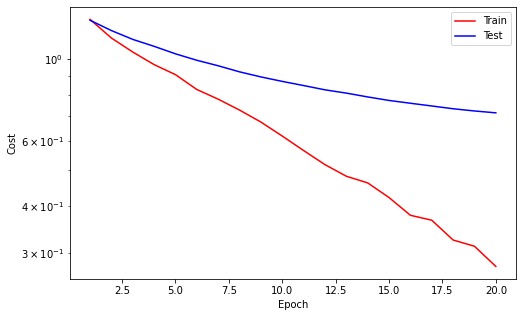

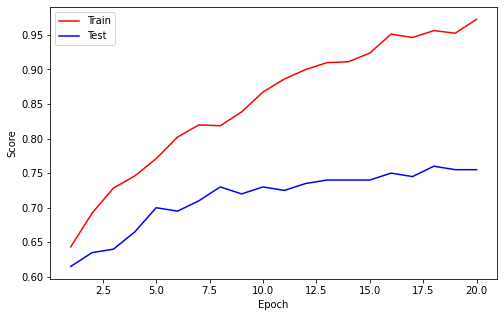

==> EarlyStop patience =  2 | Best test_score: 0.7600


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2520 | Test_cost  = 0.7036 | Train_score = 0.9775 | Test_score = 0.7600 |
==> EarlyStop patience =  3 | Best test_score: 0.7600


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2303 | Test_cost  = 0.6973 | Train_score = 0.9800 | Test_score = 0.7600 |
==> EarlyStop patience =  4 | Best test_score: 0.7600


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2214 | Test_cost  = 0.6864 | Train_score = 0.9837 | Test_score = 0.7400 |
==> EarlyStop patience =  5 | Best test_score: 0.7600
==> Execute Early Stopping at epoch: 23 | Best test_score: 0.7600
==> Best model is saved at model


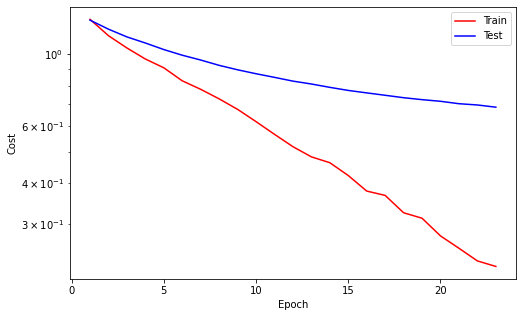

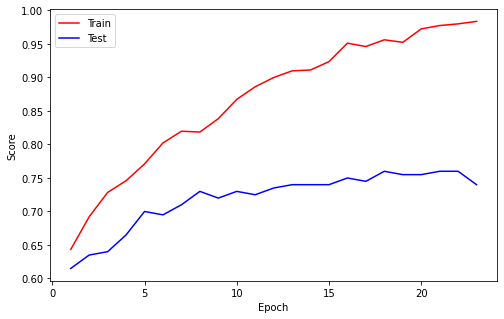

In [29]:
looping()

In [30]:
feature, target = next(iter(testLoader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([9, 7, 0, 4, 1, 9, 0, 2, 6, 1, 4, 0, 1, 2, 7, 8, 2, 5, 9, 7, 7, 5, 5, 7,
        0, 4, 6, 7, 5, 3, 4, 2], device='cuda:0')

# 6. Sanity Check

In [31]:
label2cat = dataset.classes

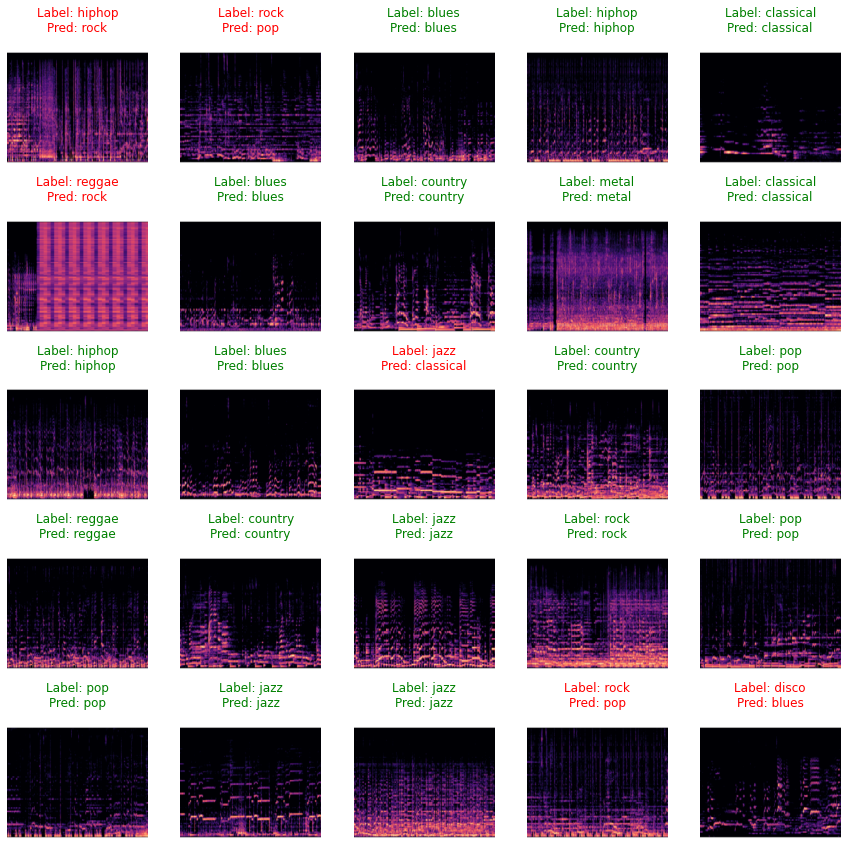

In [32]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": "r"} if (pred != label).any() else {"color": "g"}
    label, pred = label2cat[label], label2cat[pred]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')

# Model mendapatkan akurasi sebesar 76% untuk klasifikasi genre lagu berdasarkan spectogram